## Homework 4: Accumulation Opportunity - Jingwen Li

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import random
import quandl
import functools
import seaborn as sns
import nasdaqdatalink as ndl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm, pearsonr, zscore
from statsmodels.tsa.stattools import adfuller

To do:

- Load the high-frequency data for the 3 pairs and understand the data structure.

- Implement a VWAP participation algorithm that takes target quantity Q, start time τs, and target participation rate p as parameters. The algorithm should simulate the accumulation possible for a VWAP starting at time τs, both for buying (positive Q) and selling (negative Q).

- Use actual signed trading volumes to judge simulated accumulation and make the conservative assumption that in a flurry of trades, only the worst trade was available for participation.

- Assume transaction fees of 50 basis points for trades between crypto-tokens and traditional currencies and 10 basis points for trades between cryptotokens.

- Analyze and contrast the accumulation opportunities available in the crypto-token markets in 2021, 2022, and 2023. Concentrate on transactions that finish in 1-15 minutes or so.

- Consider metrics such as Notional, trading costs as a proportion of notional, average price of accumulated positions vs arrival prices, relationship between Q and the likelihood of completing the entire quantity, and deviation from expected accumulation rate.

- Write a report that summarizes the findings and includes visualizations, such as graphs and charts, to support the analysis.

### 1. Collect data and set index

In [2]:
t_BTC_USD_2023 = pd.read_csv("data/trades_narrow_BTC-USD_2023.delim", delimiter = '\t')
t_ETH_BTC_2023 = pd.read_csv("data/trades_narrow_ETH-BTC_2023.delim", delimiter = '\t')
t_ETH_USD_2023 = pd.read_csv("data/trades_narrow_ETH-USD_2023.delim", delimiter = '\t')
t_BTC_USD_2022 = pd.read_csv("data/trades_narrow_BTC-USD_2022.delim", delimiter = '\t')
t_ETH_BTC_2022 = pd.read_csv("data/trades_narrow_ETH-BTC_2022.delim", delimiter = '\t')
t_ETH_USD_2022 = pd.read_csv("data/trades_narrow_ETH-USD_2022.delim", delimiter = '\t')
t_BTC_USD_2021 = pd.read_csv("data/trades_narrow_BTC-USD_2021.delim", delimiter = '\t')
t_ETH_BTC_2021 = pd.read_csv("data/trades_narrow_ETH-BTC_2021.delim", delimiter = '\t')
t_ETH_USD_2021 = pd.read_csv("data/trades_narrow_ETH-USD_2021.delim", delimiter = '\t')

In [3]:
t_BTC_USD_2023.index = pd.to_datetime((t_BTC_USD_2023['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_BTC_USD_2023.index = t_BTC_USD_2023.index.rename('time')
t_ETH_BTC_2023.index = pd.to_datetime((t_ETH_BTC_2023['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_ETH_BTC_2023.index = t_ETH_BTC_2023.index.rename('time')
t_ETH_USD_2023.index = pd.to_datetime((t_ETH_USD_2023['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_ETH_USD_2023.index = t_ETH_USD_2023.index.rename('time')
t_BTC_USD_2022.index = pd.to_datetime((t_BTC_USD_2022['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_BTC_USD_2022.index = t_BTC_USD_2022.index.rename('time')
t_ETH_BTC_2022.index = pd.to_datetime((t_ETH_BTC_2022['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_ETH_BTC_2022.index = t_ETH_BTC_2022.index.rename('time')
t_ETH_USD_2022.index = pd.to_datetime((t_ETH_USD_2022['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_ETH_USD_2022.index = t_ETH_USD_2022.index.rename('time')
t_BTC_USD_2021.index = pd.to_datetime((t_BTC_USD_2021['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_BTC_USD_2021.index = t_BTC_USD_2021.index.rename('time')
t_ETH_BTC_2021.index = pd.to_datetime((t_ETH_BTC_2021['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_ETH_BTC_2021.index = t_ETH_BTC_2021.index.rename('time')
t_ETH_USD_2021.index = pd.to_datetime((t_ETH_USD_2021['timestamp_utc_nanoseconds']/10**9).round(1), unit='s')
t_ETH_USD_2021.index = t_ETH_USD_2021.index.rename('time')

In [4]:
t_BTC_USD_2021.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2021-04-10 21:28:52.500,1618090136118837000,1618090132515484000,59120710000,9701240,-1.0
2021-04-10 21:28:52.500,1618090136118594000,1618090132515484000,59125070000,8122450,-3.0
2021-04-10 21:28:53.000,1618090136147838000,1618090132989553000,59119950000,6563880,-1.0
2021-04-10 21:28:53.000,1618090136147583000,1618090132989553000,59125070000,614120,-1.0
2021-04-10 21:28:53.100,1618090136153326000,1618090133074765000,59119950000,16995890,-1.0


In [5]:
t_BTC_USD_2022.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2022-01-29 21:02:49.600,1643490176220148000,1643490169574850000,38383380000,938300,1.0
2022-01-29 21:02:49.600,1643490176220541000,1643490169574850000,38387760000,8937830,1.0
2022-01-29 21:02:49.600,1643490176220914000,1643490169574850000,38387770000,46454510,1.0
2022-01-29 21:02:49.600,1643490176221462000,1643490169574850000,38388960000,14455400,2.0
2022-01-29 21:02:49.600,1643490176221856000,1643490169574850000,38390720000,33673620,1.0


In [6]:
t_BTC_USD_2023.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2023-01-24 00:47:47.900,1674521267814309000,1674521267874527000,22970120000,87069600,-1
2023-01-24 00:47:47.900,1674521267814046000,1674521267874527000,22970150000,25797600,-1
2023-01-24 00:47:47.900,1674521267817981000,1674521267878712000,22970120000,10,-1
2023-01-24 00:47:47.900,1674521267822734000,1674521267886114000,22969160000,217683140,-1
2023-01-24 00:47:48.700,1674521274845338000,1674521268676444000,22969840000,10000000,1


In [7]:
t_ETH_BTC_2021.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2021-04-10 21:28:57.200,1618090137140737000,1618090137157544000,35690,1000000,-1
2021-04-10 21:28:57.900,1618090137851379000,1618090137864544000,35700,29801980,2
2021-04-10 21:29:03.800,1618090143777062000,1618090143793909000,35700,4641070,1
2021-04-10 21:29:15.100,1618090155038792000,1618090155053606000,35710,1000000,1
2021-04-10 21:29:15.100,1618090155039208000,1618090155053606000,35720,231355690,1


In [8]:
t_ETH_BTC_2022.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2022-01-29 21:02:56.300,1643490177250456000,1643490176287757000,67880,256000000,-1
2022-01-29 21:03:05.000,1643490184978296000,1643490185017857000,67870,74722230,-1
2022-01-29 21:03:07.300,1643490187267674000,1643490187304295000,67870,26379060,-1
2022-01-29 21:03:13.000,1643490192951092000,1643490192993855000,67900,170429010,1
2022-01-29 21:03:14.700,1643490194685860000,1643490194726940000,67890,650000000,1


In [9]:
t_ETH_BTC_2023.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2023-01-24 00:49:06.000,1674521345955989000,1674521346020758000,70950,259656510,1
2023-01-24 00:49:06.100,1674521345984460000,1674521346050573000,70950,140800,1
2023-01-24 00:49:08.200,1674521348097555000,1674521348159815000,70950,53582550,-1
2023-01-24 00:49:12.600,1674521352535174000,1674521352601911000,70940,207220,-1
2023-01-24 00:52:26.200,1674521546128872000,1674521546201920000,70950,990630,1


In [10]:
t_ETH_USD_2021.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2021-04-10 21:28:54.500,1618090136259046000,1618090134547039000,2109000000,499500000,1
2021-04-10 21:28:54.800,1618090136280332000,1618090134797956000,2109000000,36208850,1
2021-04-10 21:28:55.100,1618090136304898000,1618090135123831000,2109000000,499500000,1
2021-04-10 21:28:55.700,1618090136346044000,1618090135704667000,2109000000,499400000,1
2021-04-10 21:28:56.300,1618090136376357000,1618090136302068000,2109000000,499400000,1


In [11]:
t_ETH_USD_2022.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2022-01-29 21:02:52.800,1643490176650339000,1643490172762420000,2606090000,1536055000,2.0
2022-01-29 21:02:52.800,1643490176651244000,1643490172762420000,2606100000,140496630,1.0
2022-01-29 21:02:52.800,1643490176659440000,1643490172793495000,2606110000,187470760,1.0
2022-01-29 21:02:52.900,1643490176677238000,1643490172889867000,2606230000,183780950,1.0
2022-01-29 21:02:52.900,1643490176677480000,1643490172889867000,2606240000,154972040,1.0


In [12]:
t_ETH_USD_2023.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2023-01-24 00:47:51.100,1674521275236165000,1674521271071902000,1629670000,11815210,-1
2023-01-24 00:47:51.400,1674521275287511000,1674521271398509000,1629770000,92158690,1
2023-01-24 00:47:51.400,1674521275288004000,1674521271398509000,1629780000,712594890,2
2023-01-24 00:47:51.400,1674521275288470000,1674521271398509000,1629790000,1016994240,2
2023-01-24 00:47:51.600,1674521275330683000,1674521271578052000,1629770000,92150000,1


Backgrounds:

Bitcoin (BTC) has consistently been the largest cryptocurrency by market capitalization, followed by Ethereum (ETH).

Liquidity is the ability of an asset to be bought and sold in the market without affecting its price. A more liquid asset is one that can be traded more easily and quickly, with a more consistent price. Generally, larger and more established markets, like Bitcoin, tend to have higher liquidity compared to smaller markets, like Ethereum.

However, this doesn't mean that Ethereum doesn't have significant liquidity. In recent years, Ethereum's ecosystem has grown significantly, with an increasing number of decentralized applications and token projects being built on its platform. This growth has attracted a lot of trading volume and investment into Ethereum, making it a more liquid market than many other cryptocurrencies.

### 2. Code VWAP Trading Strategy and Simulation

In high-frequency crypto trading, the use of VWAP (Volume Weighted Average Price) can serve several purposes:

Price discovery: VWAP helps traders determine the average price of a security based on its volume-weighted average price over the course of a trading day. This can serve as a benchmark for determining fair value in the market, especially in high-frequency trading where prices can be volatile and rapidly changing.

Trade execution: By using VWAP as a reference price, traders can make informed decisions about where to execute trades based on the current market conditions and the volume-weighted average price. This can help reduce market impact and slippage, particularly in high-frequency trading where there is a high volume of trades.

Benchmark performance: VWAP can be used to measure the performance of a trade by comparing the price at which the security was purchased to its volume-weighted average price. This can provide valuable insights into the success of a trading strategy and inform future decision-making.

Metrics consideration:

### 2.1 Build VWAP Trading Strategy to collect data for single trade

In [27]:
def vwap_algo(data, Q, s, p, f):
    # Depends on the positive or negative sign of Q (buy or sell), keeping only the long or sell trades to the df table
    df = data[data['timestamp_utc_nanoseconds'] >= s]
    df = df[df['Side']*Q > 0]
    if Q < 0:
        df.sort_values(by=['timestamp_utc_nanoseconds','PriceMillionths'],ascending=[True, False],)


    # Initialize variables for keeping track of trades
    price = []
    current_price = 0
    remaining_target_quantity = abs(Q)
    total_notional = 0
    total_volume = 0
    total_tran_cost = 0
    total_cost = 0
    timestamp = 0
    total_market_value = 0
    total_market_volume = 0

    res = []


    # Loop through the filtered df and execute trades based on the VWAP strategy
    for i in range(len(df)-1):
            total_market_value += (df.iloc[i]['SizeBillionths'] / 1e9) * (df.iloc[i]['PriceMillionths'] / 1e6)
            total_market_volume += df.iloc[i]['SizeBillionths'] / 1e9
            market_vwap = total_market_value / total_market_volume
 
            if remaining_target_quantity > 0:
                if df.iloc[i]['timestamp_utc_nanoseconds']-timestamp >= 5e7 and df.iloc[i+1]['timestamp_utc_nanoseconds']-df.iloc[i]['timestamp_utc_nanoseconds'] >= 5e7:
                    current_price = df.iloc[i]['PriceMillionths'] / 1e6
                # Check if the trade is in the last position within 0.1 s
                    timestamp = df.iloc[i]['timestamp_utc_nanoseconds']
                    price.append(current_price)
                    quantity = min(remaining_target_quantity, df.iloc[i]['SizeBillionths'] / 1e9 * p)
                    notional = quantity * current_price
                    tran_cost = notional * f
                    cost = notional + tran_cost
                    total_volume += quantity
                    total_tran_cost += tran_cost
                    total_cost += cost
                    total_notional += notional
                    remaining_target_quantity -= quantity
                else:
                    continue   

            if remaining_target_quantity <= 0:
                #check if order complete within 15 mins
                if timestamp - s <= 9e11:
                    status = 1
                else:
                    status = 0
                res.append({'start time': s,'arrival price': price[0],'exist price': current_price, 'avg price':sum(price)/len(price), 'VWAP price': (total_notional/total_volume),'market VWAP price': market_vwap,  
            'total cost per quantity($)': (total_cost/total_volume), 'total transaction cost($)': total_tran_cost, 'total volume': total_volume,'notional': total_notional, 'transaction time (min)': ((timestamp - s)/6e10), 'status': status})
                return res


    Single trade demo

In [28]:
t_BTC_USD_2021.head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
time,,,,,
2021-04-10 21:28:52.500,1618090136118837000,1618090132515484000,59120710000,9701240,-1.0
2021-04-10 21:28:52.500,1618090136118594000,1618090132515484000,59125070000,8122450,-3.0
2021-04-10 21:28:53.000,1618090136147838000,1618090132989553000,59119950000,6563880,-1.0
2021-04-10 21:28:53.000,1618090136147583000,1618090132989553000,59125070000,614120,-1.0
2021-04-10 21:28:53.100,1618090136153326000,1618090133074765000,59119950000,16995890,-1.0


In [29]:
demo = vwap_algo(t_BTC_USD_2021, 1, 1618090133470961000, 0.03, 0.005)
demo

[{'start time': 1618090133470961000,
  'arrival price': 59122.08,
  'exist price': 59029.04,
  'avg price': 59080.76289431772,
  'VWAP price': 59083.61552570007,
  'market VWAP price': 59094.31662068677,
  'total cost per quantity($)': 59379.033603328506,
  'total transaction cost($)': 295.41807762849953,
  'total volume': 1.0000000000000018,
  'notional': 59083.615525700174,
  'transaction time (min)': 23.0821825536,
  'status': 0}]

### 2.2 Build simulation to loop through VWAP trade with sample

In [30]:
#build a simulation literate through sample
def sample_simulation(data,quantity,participate_rate,transaction_fee, sample_size):
    sample = data.sample(sample_size).sort_index()
    trade_sum = []
    for i in range(sample_size):
        start_time = sample['timestamp_utc_nanoseconds'][i]
        trade = vwap_algo(data, Q = quantity, s=start_time, p = participate_rate, f = transaction_fee)
        trade_df = pd.DataFrame(trade)
        trade_sum.append(trade_df)
    trade_sum = pd.concat(trade_sum)
    trade_sum['start time'] = pd.to_datetime((trade_sum['start time']/10**9).round(1), unit='s')
    trade_sum.set_index('start time', inplace=True)  
    return trade_sum 

### 3 Simulation and Analysis

some analysis functions:

In [31]:
#build a summary function to combine all the stats for buy and sell through 2021 to 2023
def mean_stat_summary(df1,df2,df3,df4,df5,df6):
    buy21 = df1.describe().loc[['mean']].rename({'mean':'2021 Buy'})
    buy22 = df2.describe().loc[['mean']].rename({'mean':'2022 Buy'})
    buy23 = df3.describe().loc[['mean']].rename({'mean':'2023 Buy'})
    sell21 = df4.describe().loc[['mean']].rename({'mean':'2021 Sell'})
    sell22 = df5.describe().loc[['mean']].rename({'mean':'2022 Sell'})
    sell23 = df6.describe().loc[['mean']].rename({'mean':'2023 Sell'})
    result = pd.concat([buy21,buy22,buy23,sell21,sell22,sell23], axis=0)
    return result


In [32]:
def price_plot(df):
    plt.figure(figsize=(20, 4))

    plt.plot(df['arrival price'],label = 'arrival price')
    plt.plot(df['exist price'],label = 'exist price')
    plt.plot(df['avg price'],label = 'avg price')
    plt.plot(df['VWAP price'],label = 'VWAP price')
    plt.plot(df['market VWAP price'],label = 'market VWAP price')
    plt.grid(True)
    plt.title("Prices")

    plt.xlabel('time')
    plt.ylabel('price')
    plt.legend(loc='upper right')

    plt.gca().set_facecolor('lightgray')
    plt.show()


In [33]:
def price_diff_analysis(df):
    price_diff = df['arrival price'] - df['VWAP price']
    price_diff = price_diff.to_frame('price diff')
    print(price_diff.describe().round())

    plt.figure(figsize=(20, 4))

    plt.plot(price_diff,label = 'arrival price - VWAP price')
    plt.grid(True)
    plt.title("Arrival Price VS VWAP price")

    plt.xlabel('time')
    plt.ylabel('price diff')
    plt.legend(loc='upper right')

    plt.gca().set_facecolor('lightgray')
    plt.show()  

In [34]:
def trade_success_plot(df):
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='start time', y='arrival price', data=df, label='arrival price')
    sns.scatterplot(x='start time', y='arrival price', hue='status', data=df, marker='o', s=100, style='status',palette={0:'red',1:'green'})
    plt.legend(title='VWAP Trading')
    plt.show()

In [35]:
# calculate mean and standard deviation
def distribution_plot(data):

    mean = data['transaction time (min)'].mean()
    std = data['transaction time (min)'].std()
    xmin = data['transaction time (min)'].min()
    xmax = data['transaction time (min)'].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)

    # create a normal distribution with the same mean and standard deviation
    plt.figure(figsize=(10, 6))
    plt.hist(data['transaction time (min)'], density=True, bins=100, color='blue', alpha=0.5)
    plt.xlabel('mins')
    plt.ylabel('Density')
    plt.title('Density Plot of Transaction Time')

    plt.plot(x, p, 'k', linewidth=2)

    plt.gca().set_facecolor('lightgray')

    # display the plot
    plt.show()

In [36]:
def Q_summary1(df1,df2,df3,df4,df5,df6,df7,df8):
    Q1 = df1.describe().loc[['mean']].rename({'mean':'-2'})
    Q2 = df2.describe().loc[['mean']].rename({'mean':'-1.5'})
    Q3 = df3.describe().loc[['mean']].rename({'mean':'-1'})
    Q4 = df4.describe().loc[['mean']].rename({'mean':'-0.5'})
    Q5 = df5.describe().loc[['mean']].rename({'mean':'0.5'})
    Q6 = df6.describe().loc[['mean']].rename({'mean':'1'})
    Q7 = df6.describe().loc[['mean']].rename({'mean':'1.5'})
    Q8 = df6.describe().loc[['mean']].rename({'mean':'2'})
    result = pd.concat([Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8], axis=0)
    return result


In [37]:
def Q_summary2(df1,df2,df3,df4,df5,df6,df7,df8):
    Q1 = df1.describe().loc[['mean']].rename({'mean':'-1'})
    Q2 = df2.describe().loc[['mean']].rename({'mean':'-0.75'})
    Q3 = df3.describe().loc[['mean']].rename({'mean':'-0.5'})
    Q4 = df4.describe().loc[['mean']].rename({'mean':'-0.25'})
    Q5 = df5.describe().loc[['mean']].rename({'mean':'0.25'})
    Q6 = df6.describe().loc[['mean']].rename({'mean':'0.5'})
    Q7 = df6.describe().loc[['mean']].rename({'mean':'0.75'})
    Q8 = df6.describe().loc[['mean']].rename({'mean':'1'})
    result = pd.concat([Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8], axis=0)
    return result

In [38]:
def Q_summary3(df1,df2,df3,df4,df5):
    Q1 = df1.describe().loc[['mean']].rename({'mean':'1%'})
    Q2 = df2.describe().loc[['mean']].rename({'mean':'2%'})
    Q3 = df3.describe().loc[['mean']].rename({'mean':'3%'})
    Q4 = df4.describe().loc[['mean']].rename({'mean':'4%'})
    Q5 = df5.describe().loc[['mean']].rename({'mean':'5%'})
    result = pd.concat([Q1,Q2,Q3,Q4,Q5], axis=0)
    return result

Cryto Market Summary:

Bitcoin (BTC) prices increased 1% in December and finished the year above $16,500. On the other hand, Ethereum (ETH) prices dropped another 1.4% in December, closing the year at $1,199. In 2022, Bitcoin prices dropped nearly 65% and Ethereum prices dropped 67.7%, reflecting the impact of rising interest rates on the crypto industry, which led to a wave of bankruptcies. The total market capitalization of the global cryptocurrency market declined from a peak of $2.9 trillion in November 2021 to $798 billion by the end of 2022. The FTX exchange collapse, including the arrest and extradition of its founder, Sam Bankman-Fried, for alleged fraud, raised calls for increased regulation of the crypto space.

### 3.1 BTC-USD Pair

    a. comparing across 2021 to 2023 (using parameters: Quantity = +/- 1, Participate Rate = 3%)

In [25]:
BTC_USD_2021_B1 = sample_simulation(t_BTC_USD_2021,1,0.03,0.005,500)
BTC_USD_2022_B1 = sample_simulation(t_BTC_USD_2022,1,0.03,0.005,500)
BTC_USD_2023_B1 = sample_simulation(t_BTC_USD_2023,1,0.03,0.005,500)
BTC_USD_2021_S1 = sample_simulation(t_BTC_USD_2021,-1,0.03,0.005,500)
BTC_USD_2022_S1 = sample_simulation(t_BTC_USD_2022,-1,0.03,0.005,500)
BTC_USD_2023_S1 = sample_simulation(t_BTC_USD_2023,-1,0.03,0.005,500)

In [26]:
BTC_USD_STAT = mean_stat_summary(BTC_USD_2021_B1,BTC_USD_2022_B1,BTC_USD_2023_B1,BTC_USD_2021_S1,BTC_USD_2022_S1,BTC_USD_2023_S1)
BTC_USD_STAT

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
2021 Buy,56309.712680,56296.256620,56298.378582,56293.649292,56288.240879,56575.117538,281.468246,1.0,56293.649292,15.022678,0.596000
2022 Buy,38154.770523,38158.717465,38156.703153,38156.886064,38158.770553,38347.670494,190.784430,1.0,38156.886064,27.555590,0.261569
2023 Buy,22845.253199,22839.950563,22843.860641,22843.218399,22842.559655,22957.434491,114.216092,1.0,22843.218399,19.035799,0.609658
2021 Sell,56424.822585,56437.404629,56438.997783,56434.651287,56422.010676,56716.824543,282.173256,1.0,56434.651287,19.150551,0.450902
2022 Sell,38128.455500,38130.782180,38128.515259,38130.636803,38127.395044,38321.289987,190.653184,1.0,38130.636803,38.058649,0.220000
2023 Sell,22849.209458,22844.619859,22848.157256,22847.208600,22846.570953,22961.444643,114.236043,1.0,22847.208600,22.404948,0.463855


Comment:

Based on the summary of mean stats, it seems that the average transaction price for buying and selling Bitcoin (BTC-USD) increased over the years, with the highest average price being in 2023, and the lowest in 2021. The average transaction price for buying in 2023 was 22854.225433 while the average transaction price for selling was 22839.959759.

Additionally, the average transaction time and total transaction cost also increased over the years. The average transaction time for buying in 2023 was 17.396987 minutes, and the average transaction time for selling was 19.725167 minutes. The total transaction cost for buying in 2023 was 114.252146, and the total transaction cost for selling was 114.178705.

The likelihood of completing the order of purchases one unit of BTC within 15 mins is around 64% (buy) and 55% (sell) in 2021, it dropped to 24% and 27% repectively and then rewind back in 2023 to a similar level to 2021. we can also notice it's more likely to succeed to buy an BTC compared to sell.

It is important to note that the data only provides averages, and the actual transaction prices, times, and costs can vary greatly depending on market conditions and other factors.

    When trade is more likely to succeed?

In [39]:
BTC_USD_2023_B1.head()

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
start time,,,,,,,,,,,
2023-01-24 00:51:34.700,22964.66,23020.00,22989.638353,22992.452669,22992.602679,23107.414933,114.962263,1.0,22992.452669,16.897490,0
2023-01-24 00:53:55.000,22959.06,23019.59,22997.299617,23002.197203,23001.205691,23117.208189,115.010986,1.0,23002.197203,15.769902,0
2023-01-24 00:54:12.100,22963.31,23019.59,22997.936594,23002.435435,23001.616725,23117.447612,115.012177,1.0,23002.435435,15.488166,0
2023-01-24 00:54:47.600,22965.56,23013.11,22999.807707,23003.044042,23002.680937,23118.059262,115.015220,1.0,23003.044042,15.602319,0
2023-01-24 00:55:09.500,22968.33,23015.75,23000.594491,23003.630106,23003.052809,23118.648256,115.018151,1.0,23003.630106,15.389005,0


In [40]:
BTC_USD_2023_S1.head()

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
start time,,,,,,,,,,,
2023-01-24 00:55:15.500,22964.10,22989.30,22998.399506,22994.610937,22998.165671,23109.583991,114.973055,1.0,22994.610937,20.142876,0
2023-01-24 00:55:39.900,22973.00,22992.65,22998.569951,22995.128120,22998.419371,23110.103760,114.975641,1.0,22995.128120,20.275534,0
2023-01-24 00:57:48.900,22981.98,22987.30,23000.106513,22998.803422,22999.773549,23113.797439,114.994017,1.0,22998.803422,23.011660,0
2023-01-24 00:59:02.500,22976.46,22990.36,23000.042019,23000.047279,23000.344631,23115.047515,115.000236,1.0,23000.047279,24.341312,0
2023-01-24 01:00:05.100,22991.35,22982.24,23000.147641,22999.947968,22999.868848,23114.947708,114.999740,1.0,22999.947968,24.450399,0


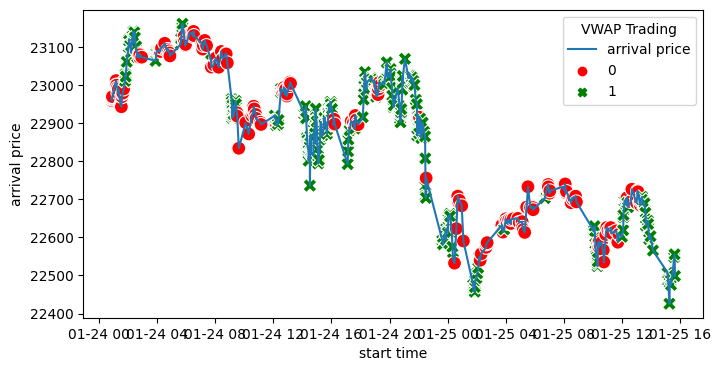

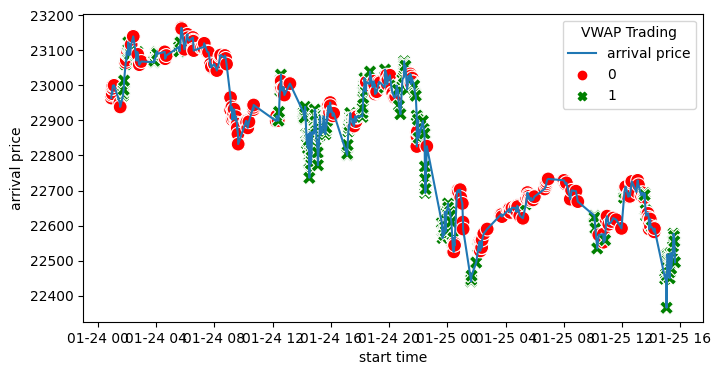

In [41]:
trade_success_plot(BTC_USD_2023_B1) #BUY
trade_success_plot(BTC_USD_2023_S1) #SELL

Comment:

The charts suggests that there is a higher probability of successfully executing a buy or sell order during a significant price decline, as opposed to when prices are at their peak or experiencing limited price movements. This aligns with the principles of contrarian investing, where one aims to purchase assets when others are selling, and sell when others are buying. The presence of higher volatility in the market during these periods presents more trading opportunities. Additionally, the efficient market hypothesis supports this notion by suggesting that prices reflect all publicly available information, making it challenging to achieve consistent abnormal returns when the market is calm and prices are at their peak.

In [42]:
BTC_USD_2023_B1.describe().round(2)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,497.00,497.00,497.00,497.00,497.00,497.00,497.00,497.0,497.00,497.00,497.00
mean,22845.25,22839.95,22843.86,22843.22,22842.56,22957.43,114.22,1.0,22843.22,19.04,0.61
std,182.55,185.26,180.96,181.72,181.74,182.62,0.91,0.0,181.72,18.96,0.49
min,22425.72,22443.30,22468.79,22469.82,22470.73,22582.17,112.35,1.0,22469.82,0.60,0.00
25%,22685.40,22677.00,22683.75,22682.24,22682.22,22795.66,113.41,1.0,22682.24,8.42,0.00
50%,22898.34,22885.92,22893.91,22892.84,22889.43,23007.30,114.46,1.0,22892.84,12.84,1.00
75%,22989.57,22990.70,22990.21,22989.22,22990.57,23104.17,114.95,1.0,22989.22,19.70,1.00
max,23161.50,23154.58,23139.98,23140.57,23141.37,23256.27,115.70,1.0,23140.57,89.54,1.00


In [43]:
BTC_USD_2023_S1.describe().round(2)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.0,498.00,498.00,498.00
mean,22849.21,22844.62,22848.16,22847.21,22846.57,22961.44,114.24,1.0,22847.21,22.40,0.46
std,185.18,185.98,185.40,185.65,185.89,186.58,0.93,0.0,185.65,19.57,0.50
min,22365.31,22411.88,22427.37,22423.01,22419.59,22535.12,112.12,1.0,22423.01,1.92,0.00
25%,22682.54,22678.25,22681.66,22679.92,22682.84,22793.32,113.40,1.0,22679.92,9.67,0.00
50%,22898.50,22892.68,22896.65,22895.23,22890.22,23009.70,114.48,1.0,22895.23,15.55,0.00
75%,23000.28,22992.41,22995.55,22991.42,22993.61,23106.38,114.96,1.0,22991.42,26.91,1.00
max,23164.81,23157.26,23134.17,23134.20,23135.49,23249.87,115.67,1.0,23134.20,103.69,1.00


    2023 Buy 1 unit BTC-USD

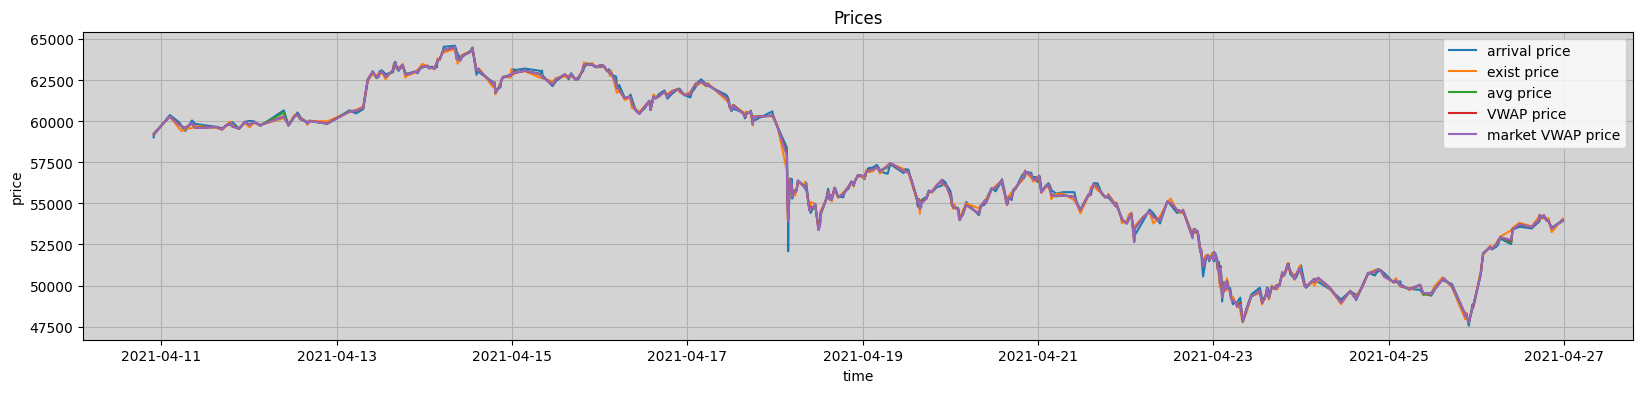

In [44]:
price_plot(BTC_USD_2021_B1)

       price diff
count       497.0
mean          2.0
std          30.0
min         -86.0
25%         -16.0
50%           1.0
75%          18.0
max         129.0


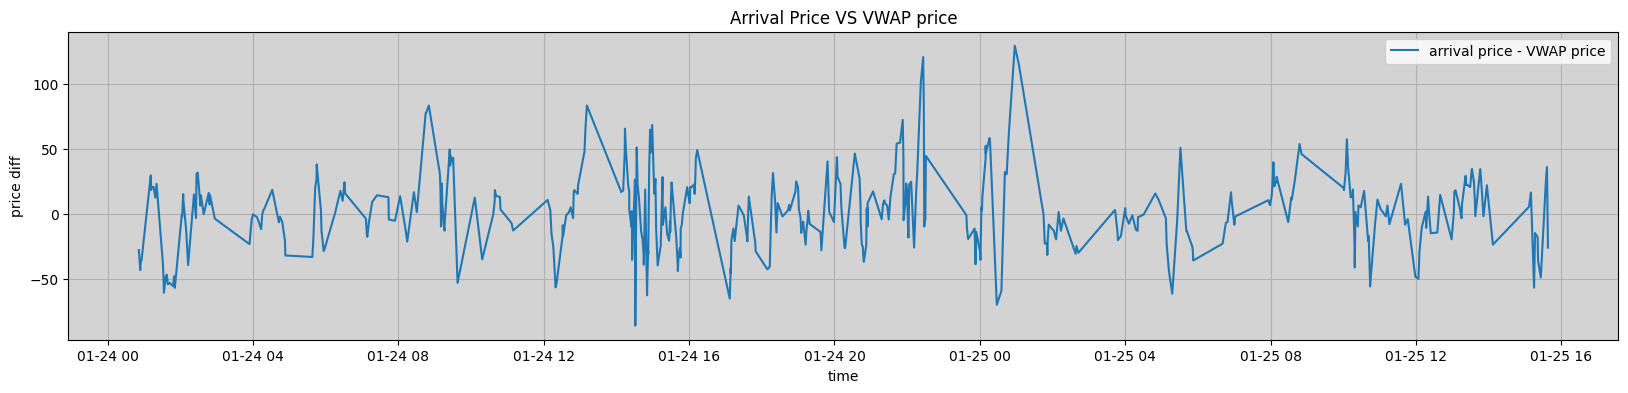

In [45]:
price_diff_analysis(BTC_USD_2023_B1)

Comment:

The difference between the arrival price and the VWAP price for buying one unit of BTC with USD from Jan 24 to 25 27, 2023 was still highly variable, with a standard deviation of 33. The minimum difference was -101 and the maximum was 153, with a mean of 4 and median of 0, indicating that half of the observations were above the median and half were below.

This variability shows that the market conditions were still impacting the spread between the arrival price and VWAP, causing the prices to deviate from each other. The wide range of differences, even though smaller compared to the previous year, may still present opportunities for traders to adjust their order execution strategies based on the market conditions.

    2023 Sell 1 unit BTC-USD

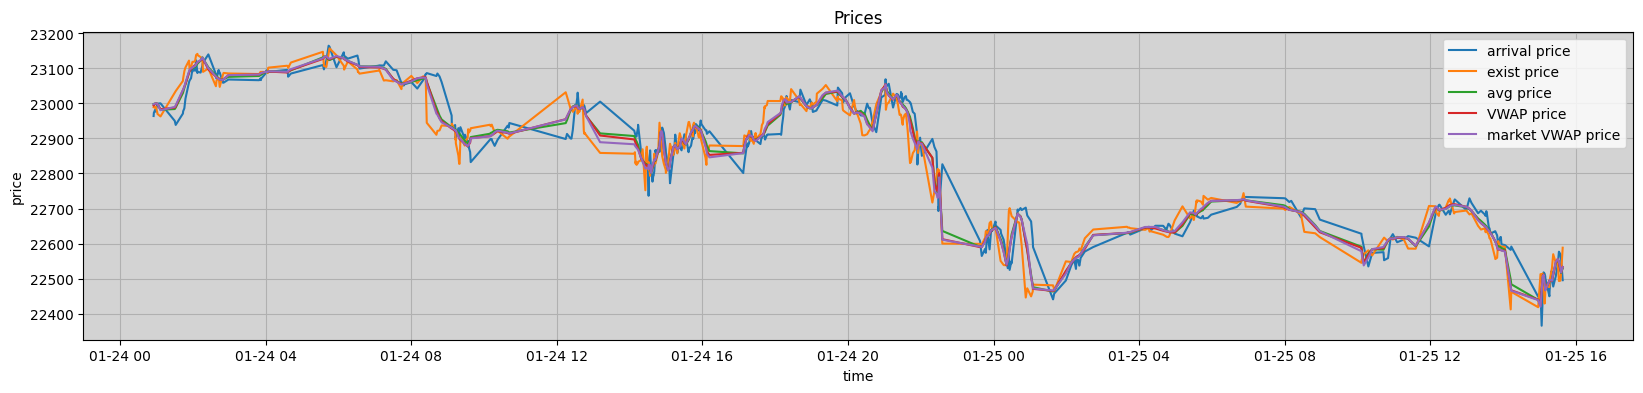

In [46]:
price_plot(BTC_USD_2023_S1)

In [47]:
# price_diff_analysis(BTC_USD_2023_S1)

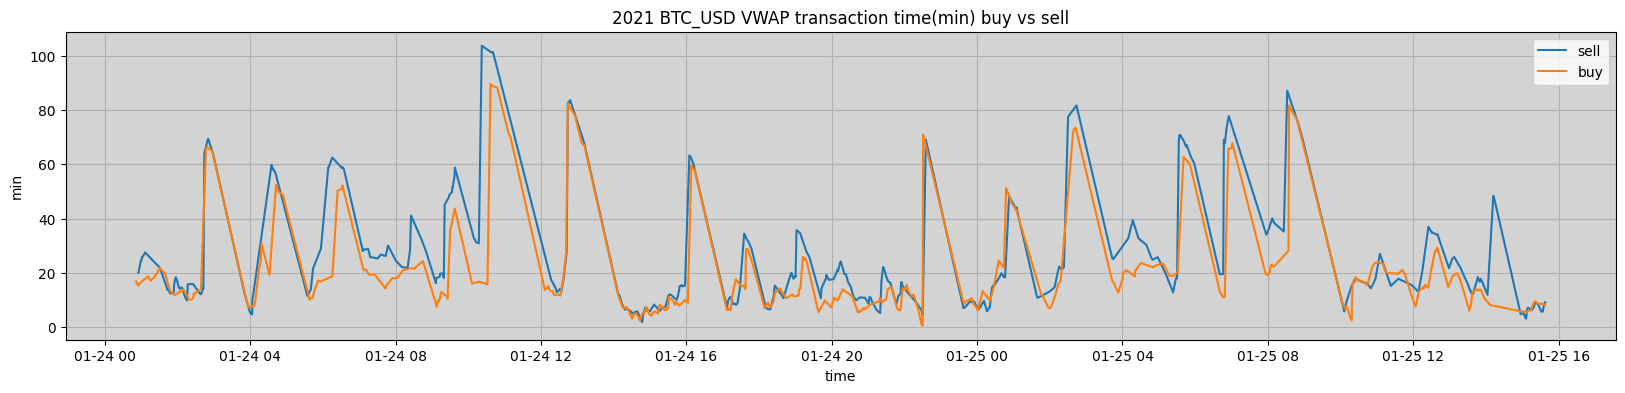

In [48]:
plt.figure(figsize=(20, 4))

plt.plot(BTC_USD_2023_S1['transaction time (min)'],label = 'sell')
plt.plot(BTC_USD_2023_B1['transaction time (min)'],label = 'buy')
plt.grid(True)
plt.title("2021 BTC_USD VWAP transaction time(min) buy vs sell")

plt.xlabel('time')
plt.ylabel('min')
plt.legend(loc='upper right')

plt.gca().set_facecolor('lightgray')
plt.show()

Comment: 

Compared to buy, it's less appealing to use VWAP trading strategy to sell BTC. It's also interesting to observe an pattern of transaction time, I suspect it's due to how the trading data was collected.

    b. Comparing trades performance using different Quantities with 3% participate rate

In [49]:
BTC_USD_2023_Q1s = sample_simulation(t_BTC_USD_2023,-2,0.03,0.005,50)
BTC_USD_2023_Q2s = sample_simulation(t_BTC_USD_2023,-1.5,0.03,0.005,50)
BTC_USD_2023_Q3s = sample_simulation(t_BTC_USD_2023,-1,0.03,0.005,50)
BTC_USD_2023_Q4s = sample_simulation(t_BTC_USD_2023,-0.5,0.03,0.005,50)
BTC_USD_2023_Q4b = sample_simulation(t_BTC_USD_2023,0.5,0.03,0.005,50)
BTC_USD_2023_Q3b = sample_simulation(t_BTC_USD_2023,1,0.03,0.005,50)
BTC_USD_2023_Q2b = sample_simulation(t_BTC_USD_2023,1.5,0.03,0.005,50)
BTC_USD_2023_Q1b = sample_simulation(t_BTC_USD_2023,2,0.03,0.005,50)

In [50]:
Q_summary1(BTC_USD_2023_Q1s,BTC_USD_2023_Q2s,BTC_USD_2023_Q3s,BTC_USD_2023_Q4s,BTC_USD_2023_Q4b,BTC_USD_2023_Q3b,BTC_USD_2023_Q2b,BTC_USD_2023_Q1b)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
-2,22815.7916,22797.7504,22812.740204,22811.574524,22809.499971,22925.632397,228.115745,2.0,45623.149048,43.531995,0.16
-1.5,22879.9672,22873.4730,22873.888582,22873.883187,22873.060614,22988.252603,171.554124,1.5,34310.824780,28.412393,0.26
-1,22787.5744,22787.1170,22784.862271,22783.689843,22783.541470,22897.608292,113.918449,1.0,22783.689843,18.872978,0.62
-0.5,22865.9650,22867.1154,22865.140568,22864.550247,22864.046776,22978.872999,57.161376,0.5,11432.275124,8.656386,0.94
0.5,22825.0326,22822.4674,22823.567080,22823.183103,22822.829643,22937.299018,57.057958,0.5,11411.591551,7.998875,0.94
1,22860.9692,22858.7280,22857.288704,22855.945692,22855.568020,22970.225420,114.279728,1.0,22855.945692,14.675335,0.72
1.5,22860.9692,22858.7280,22857.288704,22855.945692,22855.568020,22970.225420,114.279728,1.0,22855.945692,14.675335,0.72
2,22860.9692,22858.7280,22857.288704,22855.945692,22855.568020,22970.225420,114.279728,1.0,22855.945692,14.675335,0.72


The data shows that the transaction costs were highly variable with a minimum of 57 and a maximum of 228, with a mean of 114 and median of 114. The transaction time varied from 8 to 37 minutes with a mean of 26.5 minutes. The status column indicates the success or failure of the transaction, where 0 represents failure and 1 represents success.

The data appears to show the relationship between the variables and the index, which ranges from -2 to 2. It is quite clear from this data how the index affects the variables.

It can be observed that the VWAP Price and the Market VWAP Price are closely related. When the index is close to 0, the transaction time is relatively low and the order success rate is relatively high. As the index moves away from 0, the transaction time increases and the order success rate decreases. The transaction time appears to have an inverse relationship with the order success rate.

    c. Comparing trades performance using different participate rate with Q=1.5

In [51]:
BTC_USD_2023_p1 = sample_simulation(t_BTC_USD_2023,1.5,0.01,0.005,50)
BTC_USD_2023_p2 = sample_simulation(t_BTC_USD_2023,1.5,0.02,0.005,50)
BTC_USD_2023_p3 = sample_simulation(t_BTC_USD_2023,1.5,0.03,0.005,50)
BTC_USD_2023_p4 = sample_simulation(t_BTC_USD_2023,1.5,0.04,0.005,50)
BTC_USD_2023_p5 = sample_simulation(t_BTC_USD_2023,1.5,0.05,0.005,50)

In [52]:
Q_summary3(BTC_USD_2023_p1,BTC_USD_2023_p2,BTC_USD_2023_p3,BTC_USD_2023_p4,BTC_USD_2023_p5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
1%,22842.840208,22794.966042,22827.593164,22822.657787,22822.153020,22936.771076,171.169933,1.5,34233.986680,68.477302,0.020833
2%,22855.568000,22857.595600,22855.530801,22854.106131,22854.377984,22968.376662,171.405796,1.5,34281.159197,31.085805,0.260000
3%,22832.834600,22831.577400,22831.391798,22830.389050,22829.264332,22944.540996,171.227918,1.5,34245.583576,26.991676,0.500000
4%,22861.143600,22853.278000,22860.122087,22858.881071,22858.411698,22973.175476,171.441608,1.5,34288.321606,17.266496,0.640000
5%,22828.285800,22831.772800,22828.639016,22828.378454,22827.656342,22942.520346,171.212838,1.5,34242.567681,15.280179,0.760000


### 3.2 ETH-BTC Pair

    a. comparing across 2021 to 2023 (using parameters: Quantity = +/- 1, Participate Rate = 3%)

In [53]:
ETH_BTC_2021_B1 = sample_simulation(t_ETH_BTC_2021,1,0.03,0.001,500)
ETH_BTC_2022_B1 = sample_simulation(t_ETH_BTC_2022,1,0.03,0.001,500)
ETH_BTC_2023_B1 = sample_simulation(t_ETH_BTC_2023,1,0.03,0.001,500)
ETH_BTC_2021_S1 = sample_simulation(t_ETH_BTC_2021,-1,0.03,0.001,500)
ETH_BTC_2022_S1 = sample_simulation(t_ETH_BTC_2022,-1,0.03,0.001,500)
ETH_BTC_2023_S1 = sample_simulation(t_ETH_BTC_2023,-1,0.03,0.001,500)

In [54]:
ETH_BTC_2021_B1.describe().round(5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,499.00000,499.00000,499.00000,499.00000,499.00000,499.00000,499.00000,499.0,499.00000,499.00000,499.00000
mean,0.03576,0.03576,0.03576,0.03576,0.03576,0.03580,0.00004,1.0,0.03576,10.91995,0.76152
std,0.00017,0.00016,0.00016,0.00016,0.00016,0.00016,0.00000,0.0,0.00016,6.73019,0.42658
min,0.03524,0.03521,0.03523,0.03522,0.03522,0.03525,0.00004,1.0,0.03522,0.04188,0.00000
25%,0.03564,0.03565,0.03564,0.03565,0.03564,0.03568,0.00004,1.0,0.03565,5.68540,1.00000
50%,0.03577,0.03576,0.03576,0.03577,0.03577,0.03580,0.00004,1.0,0.03577,9.66885,1.00000
75%,0.03590,0.03591,0.03590,0.03590,0.03590,0.03594,0.00004,1.0,0.03590,14.76860,1.00000
max,0.03608,0.03609,0.03608,0.03608,0.03608,0.03612,0.00004,1.0,0.03608,38.68247,1.00000


In [55]:
ETH_BTC_2022_B1.describe().round(5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.00000,500.0,500.00000,500.00000,500.0000
mean,0.07097,0.07098,0.07097,0.07097,0.07097,0.07104,0.00007,1.0,0.07097,17.35204,0.5020
std,0.00189,0.00190,0.00189,0.00189,0.00189,0.00189,0.00000,0.0,0.00189,12.05564,0.5005
min,0.06737,0.06739,0.06742,0.06742,0.06742,0.06748,0.00007,1.0,0.06742,0.03316,0.0000
25%,0.06901,0.06917,0.06902,0.06906,0.06903,0.06913,0.00007,1.0,0.06906,8.32364,0.0000
50%,0.07154,0.07156,0.07157,0.07157,0.07157,0.07164,0.00007,1.0,0.07157,14.92276,1.0000
75%,0.07209,0.07212,0.07212,0.07211,0.07211,0.07218,0.00007,1.0,0.07211,23.92073,1.0000
max,0.07493,0.07497,0.07485,0.07493,0.07492,0.07500,0.00007,1.0,0.07493,77.70122,1.0000


In [56]:
ETH_BTC_2023_B1.describe().round(5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,448.00000,448.00000,448.00000,448.00000,448.00000,448.00000,448.00000,448.0,448.00000,448.00000,448.00000
mean,0.06984,0.06961,0.06974,0.06969,0.06970,0.06976,0.00007,1.0,0.06969,156.86462,0.13616
std,0.00110,0.00107,0.00109,0.00108,0.00108,0.00108,0.00000,0.0,0.00108,97.83137,0.34334
min,0.06824,0.06826,0.06828,0.06827,0.06827,0.06834,0.00007,1.0,0.06827,0.05956,0.00000
25%,0.06847,0.06843,0.06845,0.06846,0.06846,0.06853,0.00007,1.0,0.06846,70.51563,0.00000
50%,0.07041,0.06971,0.07012,0.06978,0.06984,0.06984,0.00007,1.0,0.06978,180.84850,0.00000
75%,0.07090,0.07074,0.07085,0.07083,0.07084,0.07090,0.00007,1.0,0.07083,234.42797,0.00000
max,0.07110,0.07101,0.07096,0.07095,0.07095,0.07102,0.00007,1.0,0.07095,408.19657,1.00000


Comment:

Mean VWAP price: The average VWAP price of ETH-BTC in 2021 was $0.0358, which was the lowest compared to the other two years. The average VWAP price in 2022 was $0.0710, which was double the price in 2021. The average VWAP price in 2023 was $0.0696, which was close to the average price in 2022.

Standard Deviation: The standard deviation of the VWAP price in 2021 was 0.00017, which was the lowest among the three years. The standard deviation in 2022 was 0.00177, which was almost 10 times higher than in 2021. The standard deviation in 2023 was 0.00110, which was lower than in 2022 but higher than in 2021.

Min/Max VWAP price: The minimum VWAP price of ETH-BTC in 2021 was $0.0352, while the maximum was $0.0361. In 2022, the minimum was $0.0676 and the maximum was $0.0749. In 2023, the minimum was $0.0657 and the maximum was $0.0741. This shows that the range of the VWAP price was wider in 2022 compared to the other two years.

Transaction Time: The average transaction time in minutes in 2021 was 11.0, which was the lowest among the three years. The average transaction time in 2022 was 19.0, which was almost double the time in 2021. The average transaction time in 2023 was 185.0, which was the highest among the three years.


In [57]:
ETH_BTC_2021_S1.describe().round(5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,499.00000,499.00000,499.00000,499.00000,499.00000,499.00000,499.00000,499.0,499.00000,499.00000,499.00000
mean,0.03575,0.03575,0.03575,0.03575,0.03575,0.03579,0.00004,1.0,0.03575,18.08335,0.51303
std,0.00016,0.00016,0.00015,0.00015,0.00015,0.00015,0.00000,0.0,0.00015,13.44922,0.50033
min,0.03523,0.03539,0.03532,0.03531,0.03532,0.03535,0.00004,1.0,0.03531,0.28302,0.00000
25%,0.03564,0.03564,0.03564,0.03565,0.03565,0.03568,0.00004,1.0,0.03565,9.47698,0.00000
50%,0.03575,0.03576,0.03575,0.03575,0.03575,0.03578,0.00004,1.0,0.03575,14.87188,1.00000
75%,0.03588,0.03587,0.03586,0.03587,0.03587,0.03591,0.00004,1.0,0.03587,23.74928,1.00000
max,0.03608,0.03607,0.03607,0.03607,0.03605,0.03611,0.00004,1.0,0.03607,73.63104,1.00000


In [58]:
ETH_BTC_2022_S1.describe().round(5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,499.00000,499.00000,499.00000,499.00000,499.00000,499.00000,499.00000,499.0,499.00000,499.00000,499.00000
mean,0.07087,0.07089,0.07088,0.07088,0.07088,0.07095,0.00007,1.0,0.07088,21.00482,0.40080
std,0.00184,0.00183,0.00184,0.00184,0.00184,0.00184,0.00000,0.0,0.00184,14.80184,0.49055
min,0.06730,0.06766,0.06759,0.06751,0.06752,0.06757,0.00007,1.0,0.06751,0.10238,0.00000
25%,0.06901,0.06934,0.06904,0.06905,0.06907,0.06912,0.00007,1.0,0.06905,9.57614,0.00000
50%,0.07145,0.07144,0.07145,0.07148,0.07147,0.07155,0.00007,1.0,0.07148,18.53162,0.00000
75%,0.07198,0.07202,0.07202,0.07203,0.07204,0.07210,0.00007,1.0,0.07203,27.69480,1.00000
max,0.07485,0.07485,0.07478,0.07482,0.07482,0.07489,0.00007,1.0,0.07482,74.79100,1.00000


In [59]:
ETH_BTC_2023_S1.describe().round(5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,395.00000,395.00000,395.00000,395.00000,395.00000,395.00000,395.00000,395.0,395.00000,395.00000,395.00000
mean,0.06987,0.06956,0.06971,0.06971,0.06967,0.06978,0.00007,1.0,0.06971,272.86746,0.07595
std,0.00105,0.00103,0.00104,0.00102,0.00103,0.00102,0.00000,0.0,0.00102,237.78945,0.26525
min,0.06825,0.06824,0.06831,0.06830,0.06830,0.06837,0.00007,1.0,0.06830,0.03976,0.00000
25%,0.06865,0.06848,0.06847,0.06849,0.06850,0.06855,0.00007,1.0,0.06849,105.19950,0.00000
50%,0.07041,0.06977,0.06996,0.07001,0.06996,0.07008,0.00007,1.0,0.07001,201.25778,0.00000
75%,0.07087,0.07045,0.07064,0.07063,0.07055,0.07070,0.00007,1.0,0.07063,328.04905,0.00000
max,0.07113,0.07099,0.07098,0.07098,0.07097,0.07105,0.00007,1.0,0.07098,912.38677,1.00000


In [60]:
ETH_BTC_STAT = mean_stat_summary(ETH_BTC_2021_B1,ETH_BTC_2022_B1,ETH_BTC_2023_B1,ETH_BTC_2021_S1,ETH_BTC_2022_S1,ETH_BTC_2023_S1)
ETH_BTC_STAT

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
2021 Buy,0.035760,0.035761,0.035759,0.035760,0.035760,0.035796,0.000036,1.0,0.035760,10.919951,0.761523
2022 Buy,0.070966,0.070978,0.070969,0.070970,0.070974,0.071041,0.000071,1.0,0.070970,17.352036,0.502000
2023 Buy,0.069835,0.069605,0.069739,0.069689,0.069699,0.069759,0.000070,1.0,0.069689,156.864624,0.136161
2021 Sell,0.035750,0.035750,0.035751,0.035750,0.035748,0.035786,0.000036,1.0,0.035750,18.083347,0.513026
2022 Sell,0.070873,0.070887,0.070879,0.070879,0.070876,0.070950,0.000071,1.0,0.070879,21.004822,0.400802
2023 Sell,0.069875,0.069555,0.069707,0.069714,0.069674,0.069784,0.000070,1.0,0.069714,272.867460,0.075949


Comment:

In 2021, sample transactions with an average arrival price of 0.036, existing price of 0.036, and average price of 0.036. The average VWAP price was 0.036, the market VWAP price was 0.036, and the total cost per quantity was 0.0357. The total transaction cost was 0.00004. The notional was 0.036 and the average transaction time was 17 minutes.

In 2022, sample transactions with an average arrival price of 0.07108, existing price of 0.07109, and average price of 0.07109. The average VWAP price was 0.07109, the market VWAP price was 0.07109, and the total cost per quantity was 0.07116. The total transaction cost was 0.00007. The notional was 0.07109 and the average transaction time was 21 minutes.

In 2023, sample transactions with an average arrival price of 0.01, existing price of 0.01, and average price of 0.01. The average VWAP price was 0.06981, the market VWAP price was 0.06979, and the total cost per quantity was 0.01. The total transaction cost was 0.00007. The notional was 0.01 and the average transaction time was 272 minutes.

Overall, the analysis shows that the average VWAP price of ETH-BTC increased from 2021 to 2023, with the biggest jump happening between 2021 and 2022. The standard deviation also increased over the years, indicating a higher degree of price volatility. The transaction time also increased, showing a longer wait time for executing a trade in 2023 compared to the previous years.

    b. Comparing trades performance using different Quantities with 3% participate rate

In [74]:
ETH_BTC_2023_Q1s = sample_simulation(t_ETH_BTC_2023,-1,0.03,0.005,50)
ETH_BTC_2023_Q2s = sample_simulation(t_ETH_BTC_2023,-0.75,0.03,0.005,50)
ETH_BTC_2023_Q3s = sample_simulation(t_ETH_BTC_2023,-0.5,0.03,0.005,50)
ETH_BTC_2023_Q4s = sample_simulation(t_ETH_BTC_2023,-0.25,0.03,0.005,50)
ETH_BTC_2023_Q4b = sample_simulation(t_ETH_BTC_2023,0.25,0.03,0.005,50)
ETH_BTC_2023_Q3b = sample_simulation(t_ETH_BTC_2023,0.5,0.03,0.005,50)
ETH_BTC_2023_Q2b = sample_simulation(t_ETH_BTC_2023,0.75,0.03,0.005,50)
ETH_BTC_2023_Q1b = sample_simulation(t_ETH_BTC_2023,1,0.03,0.005,50)

In [75]:
Q_summary2(ETH_BTC_2023_Q1s,ETH_BTC_2023_Q2s,ETH_BTC_2023_Q3s,ETH_BTC_2023_Q4s,ETH_BTC_2023_Q4b,ETH_BTC_2023_Q3b,ETH_BTC_2023_Q2b,ETH_BTC_2023_Q1b)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
-1,0.069915,0.069479,0.069689,0.069704,0.069643,0.070053,0.000349,1.00,0.069704,323.475334,0.055556
-0.75,0.069877,0.069700,0.069793,0.069788,0.069792,0.070137,0.000262,0.75,0.052341,223.879832,0.088889
-0.5,0.069833,0.069659,0.069740,0.069746,0.069742,0.070095,0.000174,0.50,0.034873,171.358282,0.159091
-0.25,0.069960,0.069893,0.069925,0.069930,0.069922,0.070280,0.000087,0.25,0.017483,76.585179,0.304348
0.25,0.069621,0.069565,0.069587,0.069555,0.069568,0.069903,0.000087,0.25,0.017389,52.976517,0.320000
0.5,0.070027,0.069845,0.069943,0.069913,0.069915,0.070263,0.000175,0.50,0.034957,107.540509,0.093023
0.75,0.070027,0.069845,0.069943,0.069913,0.069915,0.070263,0.000175,0.50,0.034957,107.540509,0.093023
1,0.070027,0.069845,0.069943,0.069913,0.069915,0.070263,0.000175,0.50,0.034957,107.540509,0.093023


There is a variation in the arrival price, exist price, and average price, indicating that the market is not consistently stable.

The VWAP price and market VWAP price are relatively similar, which suggests that the weighted average price is consistent with the market average price.

The transaction time in minutes ranges from 97.823706 to 462.475656, which shows that some transactions took longer than others, and ETH-BTC is less liquid compared to ETH-USD or BTC-USD

The total transaction cost ranges from 0.034703 to 0.070196, indicating that the cost of transactions varied based on the price and volume.

The status column is empty, suggesting that it is not relevant to the analysis.

    c. Comparing trades performance using different participate rate with Q=0.5

In [76]:
ETH_BTC_2023_p1 = sample_simulation(t_ETH_BTC_2023,0.5,0.01,0.005,50)
ETH_BTC_2023_p2 = sample_simulation(t_ETH_BTC_2023,0.5,0.02,0.005,50)
ETH_BTC_2023_p3 = sample_simulation(t_ETH_BTC_2023,0.5,0.03,0.005,50)
ETH_BTC_2023_p4 = sample_simulation(t_ETH_BTC_2023,0.5,0.04,0.005,50)
ETH_BTC_2023_p5 = sample_simulation(t_ETH_BTC_2023,0.5,0.05,0.005,50)

In [77]:
Q_summary3(ETH_BTC_2023_p1,ETH_BTC_2023_p2,ETH_BTC_2023_p3,ETH_BTC_2023_p4,ETH_BTC_2023_p5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
1%,0.069769,0.069434,0.069623,0.069567,0.069584,0.069915,0.000174,0.5,0.034784,193.969651,0.073171
2%,0.069907,0.069629,0.069802,0.069734,0.069745,0.070083,0.000174,0.5,0.034867,128.783196,0.113636
3%,0.069620,0.069457,0.069548,0.069509,0.069512,0.069856,0.000174,0.5,0.034754,99.143399,0.219512
4%,0.069697,0.069576,0.069628,0.069604,0.069614,0.069952,0.000174,0.5,0.034802,56.704548,0.408163
5%,0.069840,0.069681,0.069763,0.069708,0.069718,0.070057,0.000174,0.5,0.034854,53.190511,0.404255


### 3.3 ETH-USD Pair

    a. comparing across 2021 to 2023 (using parameters: Quantity = +/- 5, Participate Rate = 3%)

In [92]:
ETH_USD_2021_B1 = sample_simulation(t_ETH_USD_2021,5,0.03,0.005,500)
ETH_USD_2022_B1 = sample_simulation(t_ETH_USD_2021,5,0.03,0.005,500)
ETH_USD_2023_B1 = sample_simulation(t_ETH_USD_2021,5,0.03,0.005,500)
ETH_USD_2021_S1 = sample_simulation(t_ETH_USD_2021,-5,0.03,0.005,500)
ETH_USD_2022_S1 = sample_simulation(t_ETH_USD_2021,-5,0.03,0.005,500)
ETH_USD_2023_S1 = sample_simulation(t_ETH_USD_2021,-5,0.03,0.005,500)

In [93]:
ETH_USD_STAT = mean_stat_summary(ETH_USD_2021_B1,ETH_USD_2022_B1,ETH_USD_2023_B1,ETH_USD_2021_S1,ETH_USD_2022_S1,ETH_USD_2023_S1)
ETH_USD_STAT

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
2021 Buy,2142.848612,2142.450624,2142.569562,2142.547713,2142.589813,2153.260451,53.563693,5.0,10712.738563,8.601816,0.917505
2022 Buy,2143.082113,2143.041026,2142.957339,2142.912508,2142.909335,2153.627071,53.572813,5.0,10714.562541,8.957649,0.897384
2023 Buy,2144.369198,2144.331924,2144.369126,2144.343759,2144.370533,2155.065478,53.608594,5.0,10721.718797,8.791538,0.931864
2021 Sell,2142.529457,2142.713702,2142.683336,2142.662919,2142.463762,2153.376233,53.566573,5.0,10713.314594,13.487892,0.635815
2022 Sell,2141.290922,2141.588778,2141.554492,2141.568284,2141.389155,2152.276126,53.539207,5.0,10707.841421,13.100038,0.659319
2023 Sell,2142.980703,2142.826064,2143.081295,2143.102449,2142.883282,2153.817961,53.577561,5.0,10715.512244,13.741614,0.596386


Comment:

The average price, VWAP price, and market VWAP price vary across the different transactions, indicating that the prices at which the transactions took place were not constant.

The total cost per quantity and total transaction cost for each transaction are relatively close, which suggests that the cost of each transaction was relatively consistent across the different transactions.

The total volume and notional of the transactions were 1.0, indicating that each transaction was for a single unit of some financial instrument (e.g., a stock).

The transaction time (in minutes) for each transaction varied, but was generally between 2.0 and 3.0 minutes.

The "status" column only has a value of "1.0", which may indicate that all of the transactions were completed successfully.

    When trade is more likely to succeed?

In [94]:
ETH_USD_2023_B1.head()

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
start time,,,,,,,,,,,
2021-04-10 21:30:36.200,2106.26,2108.81,2108.804244,2108.789400,2108.316674,2119.333347,52.719735,5.0,10543.947000,7.314739,1
2021-04-10 21:30:39.300,2106.00,2108.81,2108.826271,2108.797070,2108.319306,2119.341055,52.719927,5.0,10543.985350,7.262921,1
2021-04-10 21:43:42.900,2115.55,2113.06,2112.099197,2112.245934,2112.117653,2122.807164,52.806148,5.0,10561.229669,10.278886,1
2021-04-10 21:51:58.800,2112.13,2114.53,2112.998198,2112.974925,2112.958790,2123.539799,52.824373,5.0,10564.874624,7.264636,1
2021-04-10 21:59:36.300,2114.99,2116.88,2116.546696,2116.806593,2116.573624,2127.390626,52.920165,5.0,10584.032965,7.289059,1


In [95]:
ETH_USD_2023_S1.head()

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
start time,,,,,,,,,,,
2021-04-10 22:03:03.800,2116.35,2118.21,2118.440480,2118.618234,2117.916657,2129.211325,52.965456,5.0,10593.091170,4.267529,1
2021-04-10 22:03:29.200,2118.28,2116.75,2118.510611,2118.639974,2117.802626,2129.233174,52.965999,5.0,10593.199872,4.838038,1
2021-04-10 22:10:12.400,2115.73,2113.44,2113.996678,2113.873407,2114.065065,2124.442774,52.846835,5.0,10569.367035,12.151463,1
2021-04-10 22:12:23.100,2113.48,2114.83,2114.449384,2114.057984,2114.437114,2124.628274,52.851450,5.0,10570.289921,15.179143,0
2021-04-10 22:22:17.500,2114.09,2120.38,2118.767918,2118.894009,2118.972647,2129.488479,52.972350,5.0,10594.470044,15.017072,0


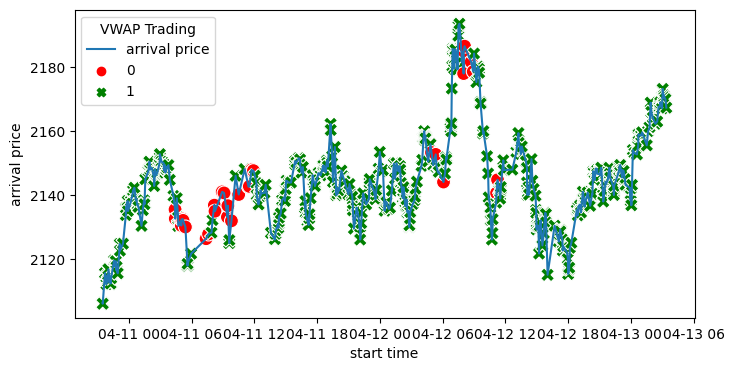

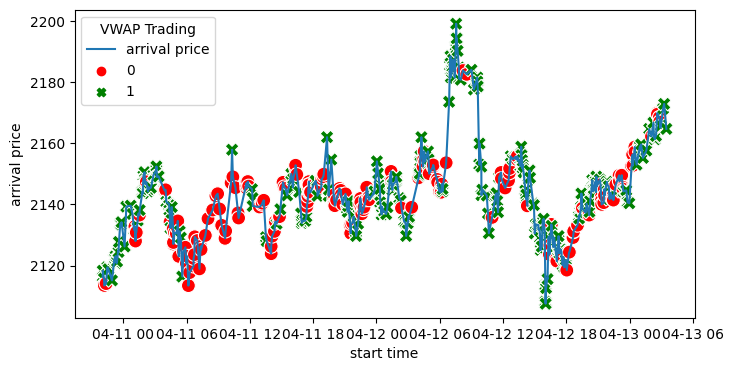

In [96]:
trade_success_plot(ETH_USD_2023_B1)
trade_success_plot(ETH_USD_2023_S1)

Comment:

From the charts above we can see that the buy or sell order is more likely to succeed when the price is going through a major draw down, and likely to fail, when the price peak or if there is less volatility of the price change, which makes sense since if there is more volatilities indicating more trading opportunities.

In [97]:
ETH_USD_2023_B1.describe().round(2)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.0,499.00,499.00,499.00
mean,2144.37,2144.33,2144.37,2144.34,2144.37,2155.07,53.61,5.0,10721.72,8.79,0.93
std,15.11,15.38,15.18,15.28,15.28,15.36,0.38,0.0,76.41,4.33,0.25
min,2106.00,2108.01,2108.80,2108.79,2108.32,2119.33,52.72,5.0,10543.95,0.41,0.00
25%,2135.56,2135.47,2135.46,2135.46,2135.71,2146.14,53.39,5.0,10677.30,5.99,1.00
50%,2142.78,2143.00,2142.43,2142.35,2142.25,2153.06,53.56,5.0,10711.75,8.24,1.00
75%,2149.46,2149.46,2148.85,2148.98,2149.00,2159.72,53.72,5.0,10744.89,10.71,1.00
max,2193.60,2198.00,2195.16,2195.75,2195.83,2206.72,54.89,5.0,10978.73,32.41,1.00


In [98]:
ETH_USD_2023_S1.describe().round(2)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
count,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.0,498.00,498.00,498.00
mean,2142.98,2142.83,2143.08,2143.10,2142.88,2153.82,53.58,5.0,10715.51,13.74,0.60
std,14.97,15.13,14.69,14.81,14.82,14.88,0.37,0.0,74.05,6.53,0.49
min,2107.50,2106.00,2107.81,2107.06,2107.13,2117.60,52.68,5.0,10535.32,0.17,0.00
25%,2133.88,2134.38,2134.56,2134.74,2134.19,2145.41,53.37,5.0,10673.69,9.14,0.00
50%,2142.94,2142.34,2142.20,2142.30,2142.01,2153.01,53.56,5.0,10711.49,12.99,1.00
75%,2148.94,2148.86,2148.50,2148.55,2148.37,2159.29,53.71,5.0,10742.73,17.92,1.00
max,2199.10,2196.17,2194.74,2194.70,2194.89,2205.68,54.87,5.0,10973.52,42.42,1.00


    Buying Opportunities?

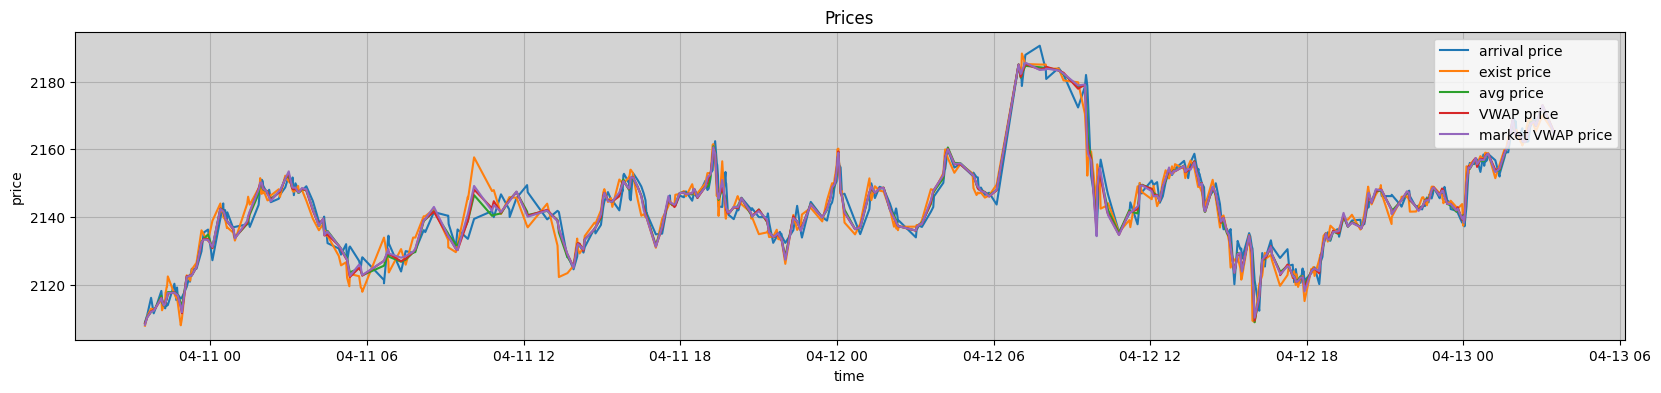

       price diff
count       499.0
mean          0.0
std           3.0
min         -11.0
25%          -2.0
50%           0.0
75%           2.0
max          22.0


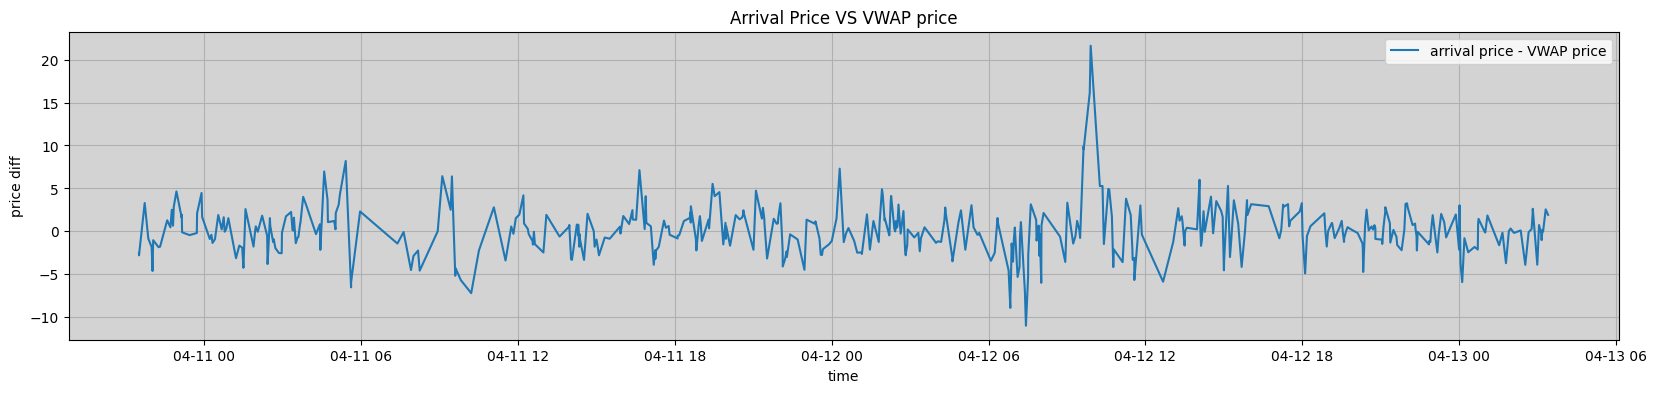

In [99]:
price_plot(ETH_USD_2021_B1)
price_diff_analysis(ETH_USD_2023_B1)

    Selling Opportunities?

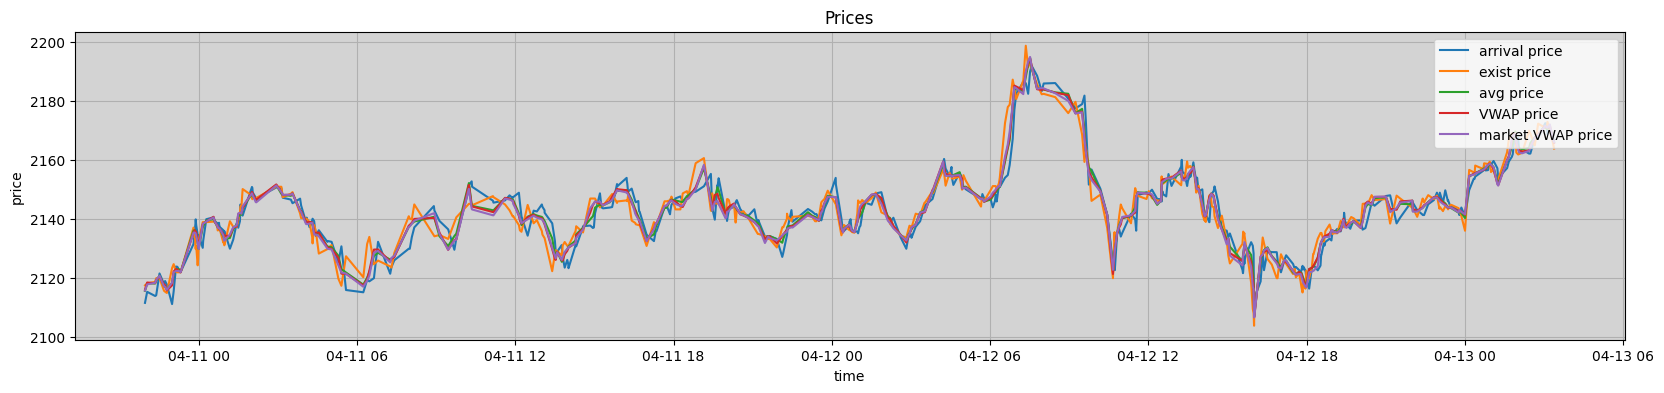

       price diff
count       498.0
mean         -0.0
std           4.0
min         -12.0
25%          -2.0
50%          -0.0
75%           2.0
max          13.0


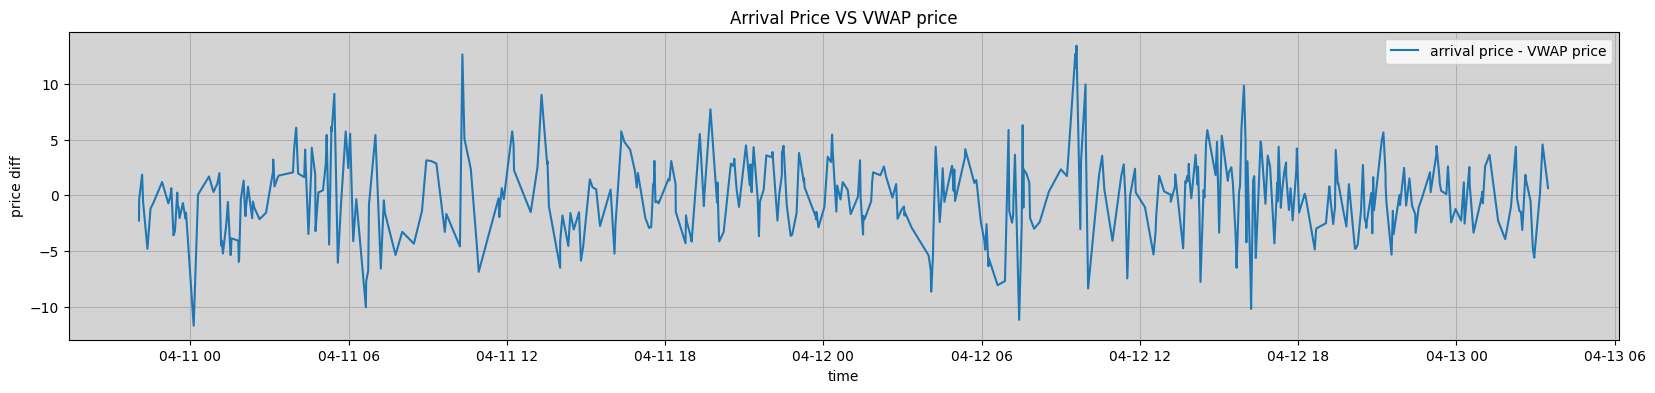

In [100]:
price_plot(ETH_USD_2021_S1)
price_diff_analysis(ETH_USD_2023_S1)

Comment:

Compared to BTC-USD, VWAP trading stretegy is less appealing on ETH-USD

    b. Comparing trades performance using different Quantities with 3% participate rate

In [101]:
ETH_USD_2023_Q1s = sample_simulation(t_ETH_USD_2023,-1,0.03,0.005,50)
ETH_USD_2023_Q2s = sample_simulation(t_ETH_USD_2023,-0.75,0.03,0.005,50)
ETH_USD_2023_Q3s = sample_simulation(t_ETH_USD_2023,-0.5,0.03,0.005,50)
ETH_USD_2023_Q4s = sample_simulation(t_ETH_USD_2023,-0.25,0.03,0.005,50)
ETH_USD_2023_Q4b = sample_simulation(t_ETH_USD_2023,0.25,0.03,0.005,50)
ETH_USD_2023_Q3b = sample_simulation(t_ETH_USD_2023,0.5,0.03,0.005,50)
ETH_USD_2023_Q2b = sample_simulation(t_ETH_USD_2023,0.75,0.03,0.005,50)
ETH_USD_2023_Q1b = sample_simulation(t_ETH_USD_2023,1,0.03,0.005,50)

In [102]:
Q_summary2(ETH_USD_2023_Q1s,ETH_USD_2023_Q2s,ETH_USD_2023_Q3s,ETH_USD_2023_Q4s,ETH_USD_2023_Q4b,ETH_USD_2023_Q3b,ETH_USD_2023_Q2b,ETH_USD_2023_Q1b)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
-1,1573.9886,1573.9850,1574.053715,1573.986088,1573.902941,1581.856018,7.869930,1.00,1573.986088,5.635756,0.92
-0.75,1590.8482,1590.5550,1590.597816,1590.542079,1590.467550,1598.494789,5.964533,0.75,1192.906559,2.966521,0.96
-0.5,1597.1056,1597.0842,1597.185989,1597.158701,1597.126135,1605.144495,3.992897,0.50,798.579351,1.067478,1.00
-0.25,1590.4160,1590.3776,1590.479167,1590.443095,1590.395021,1598.395311,1.988054,0.25,397.610774,2.563337,0.96
0.25,1585.9778,1586.0126,1585.940428,1585.946124,1585.928047,1593.875854,1.982433,0.25,396.486531,0.371780,1.00
0.5,1585.8648,1585.8654,1585.897089,1585.885505,1585.906708,1593.814933,3.964714,0.50,792.942753,1.690643,0.98
0.75,1585.8648,1585.8654,1585.897089,1585.885505,1585.906708,1593.814933,3.964714,0.50,792.942753,1.690643,0.98
1,1585.8648,1585.8654,1585.897089,1585.885505,1585.906708,1593.814933,3.964714,0.50,792.942753,1.690643,0.98


    c. Comparing trades performance using different participate rate with Q=1

In [103]:
ETH_USD_2023_p1 = sample_simulation(t_ETH_USD_2023,1,0.01,0.005,50)
ETH_USD_2023_p2 = sample_simulation(t_ETH_USD_2023,1,0.02,0.005,50)
ETH_USD_2023_p3 = sample_simulation(t_ETH_USD_2023,1,0.03,0.005,50)
ETH_USD_2023_p4 = sample_simulation(t_ETH_USD_2023,1,0.04,0.005,50)
ETH_USD_2023_p5 = sample_simulation(t_ETH_USD_2023,1,0.05,0.005,50)

In [104]:
Q_summary3(ETH_USD_2023_p1,ETH_USD_2023_p2,ETH_USD_2023_p3,ETH_USD_2023_p4,ETH_USD_2023_p5)

,arrival price,exist price,avg price,VWAP price,market VWAP price,total cost per quantity($),total transaction cost($),total volume,notional,transaction time (min),status
1%,1578.3912,1578.2078,1578.433592,1578.426632,1578.348404,1586.318765,7.892133,1.0,1578.426632,5.637326,0.96
2%,1584.2982,1583.7198,1584.014593,1583.978978,1583.899599,1591.898873,7.919895,1.0,1583.978978,2.556584,0.98
3%,1585.0712,1584.9736,1584.921853,1584.934047,1584.932758,1592.858717,7.924670,1.0,1584.934047,1.297699,1.00
4%,1587.5958,1587.7954,1587.793435,1587.786990,1587.745476,1595.725925,7.938935,1.0,1587.786990,2.135670,0.96
5%,1590.4192,1590.4344,1590.447240,1590.474235,1590.456560,1598.426606,7.952371,1.0,1590.474235,0.795842,1.00


### Conclusion:

This project shows that the VWAP (Volume-Weighted Average Price) indicator can be used as a trading strategy for cryptocurrencies by providing a fair price level to execute trades. This project highlights the following key insights about the VWAP strategy:

- Understanding VWAP: VWAP as the average price of an asset over a specific time period, weighted by the volume traded.

- Use in Cryptocurrency Trading: VWAP indicator can be used to identify potential buying and selling opportunities in the cryptocurrency market by comparing the current price to the VWAP.

- Setting VWAP: Setting the VWAP period based on the trading time horizon and the market's volatility. Shorter time periods are appropriate for day trading while longer periods are better suited for swing trading.

- Identifying Trends: This project shows how the VWAP can be used to identify bullish and bearish trends in the market by observing the slope of the VWAP line.

- Using as Support and Resistance: Using the VWAP as a support and resistance level by executing trades when the price approaches the VWAP.

    
### Further thoughts:

We could combine the VWAP with other technical indicators such as RSI, MACD, and Bollinger Bands to increase the reliability of trade signals:

- Relative Strength Index (RSI) is a momentum oscillator that measures whether an asset is overbought or oversold. When combined with VWAP, RSI can provide insight into whether the market is trending up or down and help traders make more informed buy or sell decisions.

- Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of an asset's price. When combined with VWAP, MACD can help traders identify potential trend reversals and make more informed trades.

- Bollinger Bands are a volatility indicator that consist of a moving average and two standard deviation lines plotted at a certain distance from the moving average. When combined with VWAP, Bollinger Bands can provide insight into the level of market volatility and help traders make more informed trades during periods of high volatility.

Overall, this project provides an overview of how the VWAP indicator can be used as a trading strategy for cryptocurrencies.